In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict
from sklearn.metrics import accuracy_score

In [2]:
class LogisticRegression:
    def __init__(self, lr = 0.01, n_epochs = 100, batch_size = 1, shuffle = False, threshold = 0.5, w = None, random_state = 42, verbose = 1):
        self.lr = lr # learning rate - speed of learning of model
        self.n_epochs = n_epochs # the number of learning
        self.batch_size = batch_size # the number of sample select from train set to training
        self.shuffle = shuffle # Do you want swap all sample in training of each epoch?
        self.threshold = threshold # threshold to inference of model which decision the class of sample
        self.train_Losses = [] # list loss-train_set of model of each epoch
        self.train_accuracies = [] # list accuracy-train_set of model of each epoch
        self.val_Losses = [] # list loss-val_set of model of each epoch
        self.val_accuracies = [] # list accuracy-val_set of model of each epoch
        self.Nsamples = None # the number of samples which has in training set
        self.Nfeatures  = None # the number of feature which has in training set
        self.w = w # matrix weight of models
        np.random.seed(random_state)
        if verbose == 0 or verbose == 1 or verbose == 2:
            self.verbose = verbose # the parameter allows type of the print in training process
        else: 
            raise ValueError("verbose must be 0 - don't print\n1 - print the process of batch in each epoch\n2 - print the proccess of epoch ")
        # Số batch sẽ được lấy ra huấn luyện dựa trên batch_size và số sample huấn luyện
        self.batch_number = None

        # Tập validation
        self.X_val, self.y_val = None, None
        # 
    
    # ----------------------------------------------------------------------------------------------
    # function to check dimensional of matrix 
    def CheckDim(self,X):
        if X.ndim == 1:
            raise ValueError("X must be 2 - Dimensional")
        return 1
        
    #-----------------------------------------------------------------------------------------------
    # function to add feature have value = 1 on head each sample
    def addFeature1(self,X):
        if self.CheckDim(X):
            if X.shape[1] == self.Nfeatures +1: return X
            feature1 = np.ones((X.shape[0],1))
            return np.concatenate((feature1,X), axis = 1)

    #----------------------------------------------------------------------------------------------
    # activate function - sigmoid function
    def sigmoid(self,z):
        return 1/(1+np.e**(-z))
    
    # ----------------------------------------------------------------------------------------------
    # function to compute y_pred
    def predict_prob(self,X):
        X = self.addFeature1(X)
        # compute z
        z = X@self.w
        return self.sigmoid(z)

    # -----------------------------------------------------------------------------------------------
    # function to desion the class of sample - inference of model
    def predict(self,X):
        y_prob = self.predict_prob(X)
        return np.where(y_prob>self.threshold, 1, 0)

    # -----------------------------------------------------------------------------------------------
    # function to compute Loss
    def Compute_Loss(self, y, y_prob):
        # Giới hạn giá trị max_min của y_prob để tránh việc không biểu diễn được underflow, overflow
        y_prob = np.clip(y_prob,1e-07,1 - 1e-07)
        BCE = np.mean(-y*np.log(y_prob) - (1-y)*np.log(1-y_prob))
        return BCE

    # -----------------------------------------------------------------------------------------------
    # function to compute derivative dL/dw
    def dL_dw(self,X, y, y_prob):
        return X.T@(y_prob - y)*(1/X.shape[0])

    # ----------------------------------------------------------------------------------------------
    # function to train model
    def fit(self, X, y,X_val=None,y_val=None):
        if self.CheckDim(X):
            self.Nsamples, self.Nfeatures = X.shape
        # add features have value = 1 for head each sample
        X = self.addFeature1(X)
        # reshape array y -> matrix (m,1)
        y = y.reshape(-1,1)
        if self.w is None:
            self.w = np.random.uniform(low=-1, high=1, size=(self.Nfeatures +1 ,1))
        else: self.CheckDim(self.w)
        data_train = np.concatenate((X,y), axis = 1) 
        for epoch in range(self.n_epochs):
            if self.shuffle: np.random.shuffle(data_train)
            train_loss_epoch = [] # loss-train of 1 epoch
            train_accuracy_epoch = [] # accuracy-train of 1 epoch
            self.batch_number = (self.Nsamples//self.batch_size) +1 if self.Nsamples % self.batch_size != 0 else self.Nsamples//self.batch_size
            batch_cout = 1 # variable to cout the batch number of epoch
            for i in range(0, self.Nsamples, self.batch_size):
                batch = data_train[i:i+self.batch_size]
                X_train, y_train = batch[:,:-1], batch[:,-1].reshape(-1,1)
                y_prob = self.predict_prob(X_train)
                # decision the class
                y_pred = self.predict(X_train)
                # accuracy-train of 1 batch
                train_accuracy = np.mean(y_pred == y_train)
                train_accuracy_epoch.append(train_accuracy)
                # loss-train of 1 batch 
                train_loss = self.Compute_Loss(y_train,y_prob)
                train_loss_epoch.append(train_loss)
                if self.verbose == 1:
                    if batch_cout == 1:
                        print(f"Epoch {epoch +1:<3}/{self.n_epochs}")
                    print(f"==> [{batch_cout}/{self.batch_number:<3}] =========== Loss-Train = {train_loss_epoch[-1]:<10.4f} ============ Accuracy-Train = {train_accuracy_epoch[-1]:<10.4f}")
                # compute derivative 
                dL_dw = self.dL_dw(X_train,y_train, y_prob)
                # update weight 
                self.w -= self.lr*dL_dw
                batch_cout +=1
            if X_val is not None and y_val is not None:
                self.X_val = self.addFeature1(X_val)
                self.y_val = y_val.reshape(-1,1)
                y_val_prob = self.predict_prob(self.X_val)
                y_val_pred = self.predict(self.X_val)
                val_Loss = self.Compute_Loss(self.y_val, y_val_prob)
                val_acc = np.mean(y_val_pred == self.y_val)
                self.val_Losses.append(val_Loss)
                self.val_accuracies.append(val_acc)
            self.train_Losses.append(sum(train_loss_epoch)/len(train_loss_epoch))
            self.train_accuracies.append(sum(train_accuracy_epoch)/len(train_accuracy_epoch))
            if self.verbose == 2:
                val_loss_show = self.val_Losses[-1].item() if len(self.val_Losses) else float('nan')
                val_acc_show = self.val_accuracies[-1].item() if len(self.val_accuracies) else float('nan')
                print(f"Epoch {epoch+1:<3}/{self.n_epochs} ========== Loss-Train = {self.train_Losses[-1].item():<12.4f}==============  Accuracy-Train = {self.train_accuracies[-1].item():<10.4f}========== Loss-Val = {val_loss_show:<12.4f}==============  Accuracy-Val = {val_acc_show:<10.4f}")

In [3]:
FILE_PATH = 'dataset/sentiment_analysis.csv'

In [4]:
df = pd.read_csv(FILE_PATH,index_col="id")
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


# Lấy các thông tin cơ bản của bộ dữ liệu

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


# Preprocessing

In [6]:
# text normalization - chuẩn hóa tiền xử lý DL text
def Text_normalization(text):
    # remove "RT" đằng trước văn bản
    text = re.sub(r'^RT[\s]+','',text)
    # remove hyperlink
    text = re.sub(r'https?:\/\/.*[\r\n]*','',text)
    # remove hastag và các dấu câu
    text = re.sub(r'[^\w\s]','',text)
    # Tokenization -> Chuyển các từ về list các từ 
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokened = tokenizer.tokenize(text)
    return text_tokened

In [7]:
text_sample = df.iloc[1,1]

In [8]:
text_sample

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [9]:
Text_normalization(text_sample)

['finally',
 'a',
 'transparant',
 'silicon',
 'case',
 'thanks',
 'to',
 'my',
 'uncle',
 'yay',
 'sony',
 'xperia',
 's',
 'sonyexperias']

In [10]:
# Biểu diễn text dưới dạng vector có dạng như sau
# [bias, số lần suất hiện của các từ trong text là positive, số lần xuất hiện của các từ trong text là negative]
# Hàm xây dựng từ điển số liền xuất hiện của một từ khóa trong text là positive hoặc negative
def get_frequencys(df):
    # Gán giá trị mặc định cho key = 0 nếu key đó chưa tồn tại trong dict
    freqs = defaultdict(lambda:0)
    for idx, row in df.iterrows():
        tweet  = row['tweet']
        label = row['label']

        tokens = Text_normalization(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair]+=1
    return freqs

In [11]:
freqs = get_frequencys(df)

In [12]:
freqs

defaultdict(<function __main__.get_frequencys.<locals>.<lambda>()>,
            {('fingerprint', 0): 4,
             ('pregnancy', 0): 1,
             ('test', 0): 8,
             ('finally', 0): 168,
             ('a', 0): 727,
             ('transparant', 0): 1,
             ('silicon', 0): 1,
             ('case', 0): 228,
             ('thanks', 0): 94,
             ('to', 0): 876,
             ('my', 0): 1227,
             ('uncle', 0): 4,
             ('yay', 0): 63,
             ('sony', 0): 701,
             ('xperia', 0): 54,
             ('s', 0): 38,
             ('sonyexperias', 0): 1,
             ('we', 0): 159,
             ('love', 0): 385,
             ('this', 0): 456,
             ('would', 0): 95,
             ('you', 0): 557,
             ('go', 0): 67,
             ('talk', 0): 12,
             ('makememories', 0): 1,
             ('unplug', 0): 2,
             ('relax', 0): 31,
             ('iphone', 0): 2905,
             ('smartphone', 0): 61,
             ('w

In [13]:
def get_features_vector(text,freqs):
    tokens = Text_normalization(text)
    x = np.zeros(3)
    x[0] = 1
    for token in tokens:
        x[1] += freqs[(token,1)]
        x[2] += freqs[(token,0)]
    return x

In [14]:
# Xây dựng feature
def create_Feature(df):
    X = []
    for tweet in df['tweet']:
        feature_text = get_features_vector(tweet,freqs)
        X.append(feature_text)
    return np.array(X)

In [15]:
X = create_Feature(df)

In [16]:
X

array([[1.000e+00, 2.000e+00, 1.300e+01],
       [1.000e+00, 2.788e+03, 4.183e+03],
       [1.000e+00, 1.425e+03, 4.768e+03],
       ...,
       [1.000e+00, 4.635e+03, 6.175e+03],
       [1.000e+00, 1.959e+03, 3.814e+03],
       [1.000e+00, 3.181e+03, 6.160e+03]])

In [17]:
y = df['label'].to_numpy()

In [18]:
# Chia dữ liệu train, validation, test
val_size = 0.2
random_state = 42
X_,X_val,y_,y_val = train_test_split(X,y,test_size=val_size,random_state=random_state, shuffle=True)

In [19]:
test_size = 0.125
random_state = 42
X_train,X_test,y_train,y_test = train_test_split(X_,y_,test_size=test_size,random_state=random_state, shuffle=True)

In [20]:
# Chuẩn hóa DL 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
X_train

array([[ 0.        ,  1.83510432,  0.82496345],
       [ 0.        , -0.21443757,  1.59609718],
       [ 0.        ,  0.16185713,  0.7776503 ],
       ...,
       [ 0.        ,  0.40677094,  0.57074354],
       [ 0.        , -0.09693843, -0.66363537],
       [ 0.        , -1.14600245, -1.17313445]])

# Khởi tạo mô hình và huấn luyện

In [22]:
lr = 0.01
n_epochs = 100
random_state = 12
batch_size = 32
is_shuffle = True
verbose = 2
clf = LogisticRegression(lr=lr, n_epochs=n_epochs, random_state=random_state, batch_size=batch_size, shuffle=is_shuffle,verbose=verbose)

In [23]:
clf.fit(X_train,y_train,X_val,y_val)

Epoch 1  /100 ========== Loss-Train = 0.6208      ==============  Accuracy-Train = 0.7450    ========== Loss-Val = 0.5804      ==============  Accuracy-Val = 0.7266    
Epoch 2  /100 ========== Loss-Train = 0.5356      ==============  Accuracy-Train = 0.7486    ========== Loss-Val = 0.5313      ==============  Accuracy-Val = 0.7348    
Epoch 3  /100 ========== Loss-Train = 0.5008      ==============  Accuracy-Train = 0.7633    ========== Loss-Val = 0.5071      ==============  Accuracy-Val = 0.7544    
Epoch 4  /100 ========== Loss-Train = 0.4813      ==============  Accuracy-Train = 0.7744    ========== Loss-Val = 0.4912      ==============  Accuracy-Val = 0.7626    
Epoch 5  /100 ========== Loss-Train = 0.4668      ==============  Accuracy-Train = 0.7825    ========== Loss-Val = 0.4794      ==============  Accuracy-Val = 0.7664    
Epoch 6  /100 ========== Loss-Train = 0.4570      ==============  Accuracy-Train = 0.7863    ========== Loss-Val = 0.4698      ==============  Accuracy-Val

# Visualization Accuracy and Loss

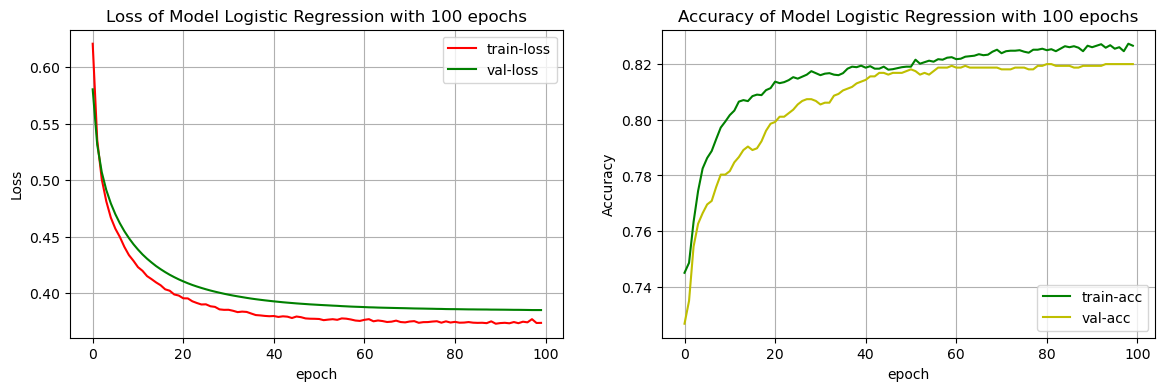

In [24]:
plt.subplots(1,2,figsize = (14,4))
plt.subplot(1,2,1)
plt.title(f"Loss of Model Logistic Regression with {clf.n_epochs} epochs")
plt.plot(clf.train_Losses,'r',label = 'train-loss')
plt.plot(clf.val_Losses,'g',label = 'val-loss')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title(f"Accuracy of Model Logistic Regression with {clf.n_epochs} epochs")
plt.plot(clf.train_accuracies,'g',label = 'train-acc')
plt.plot(clf.val_accuracies,'y',label = 'val-acc')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

# Đánh giá độ chính xác của mô hình

In [25]:
y_pred = clf.predict(X_test)

In [26]:
print(f"Độ chính xác của mô hình: {accuracy_score(y_pred,y_test):.4f}")

Độ chính xác của mô hình: 0.8460


In [32]:
text_test = pd.DataFrame({"tweet":["Absolutely loving the new update! The interface is so smooth and the dark mode looks stunning. Best user experience I've had in a long time. #happy #tech"]})

In [33]:
text_test

,tweet
0,Absolutely loving the new update! The interfac...


In [34]:
X_test = create_Feature(text_test)

In [35]:
X_test = scaler.transform(X_test)
X_test

array([[0.        , 1.35965423, 0.96725598]])

In [36]:
clf.predict(X_test)

array([[1]])